In [1]:
# Импортируем библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

pd.options.display.max_colwidth = 200

In [3]:
#Загрузка данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test2.csv')
submission = pd.read_csv('submission.csv')
train.shape, test.shape

((5282, 20), (1761, 19))

In [4]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'


In [5]:
#Случайный сэмпл
train.sample(5)


#Информация по столбцам - null нет
train.info()

(train.isna() | train.isnull()).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [6]:
#В столбце TotalSpent есть пропуски, заполним
(train.TotalSpent == ' ').sum(), (test.TotalSpent == ' ').sum()

(9, 2)

In [7]:
total_spent = pd.to_numeric(train.TotalSpent, errors='coerce')
train.TotalSpent = total_spent.fillna(0) # total_spent.mean()
total_spent = pd.to_numeric(test.TotalSpent, errors='coerce')
test.TotalSpent = total_spent.fillna(0)

In [8]:
#Анализ данных

#Числовые фичи
num_cols



['ClientPeriod', 'MonthlySpending', 'TotalSpent']

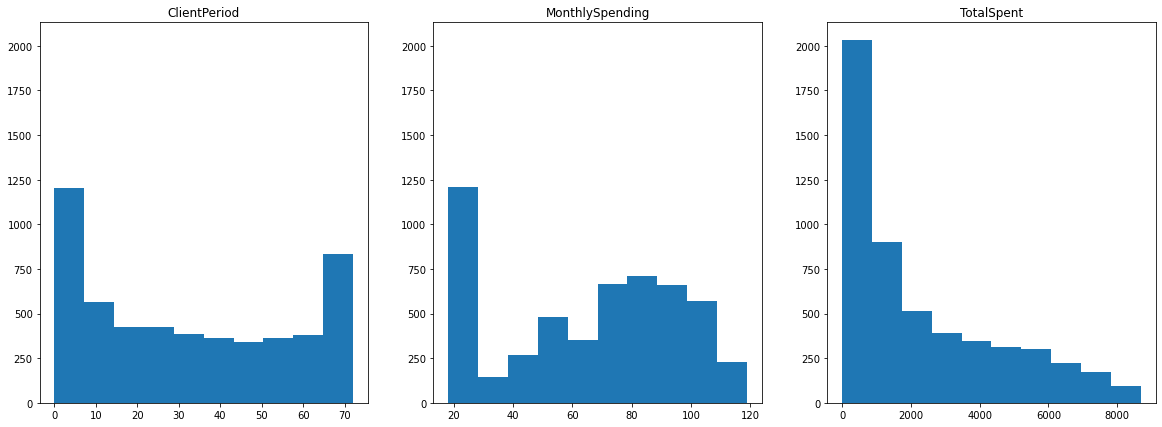

In [9]:
plt.figure(figsize=(20, 7))
ax = None
for i, column in enumerate(num_cols):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    ax.set_title(column)
    plt.hist(train[column])
plt.show()

In [10]:
out = list()
for column in cat_cols: 
  out.append([column, train[column].nunique(), dict(train[column].value_counts())])
pd.DataFrame(out, columns=['column', 'num_uniq', 'count_uniq'])

,column,num_uniq,count_uniq
0,Sex,2,"{'Male': 2655, 'Female': 2627}"
1,IsSeniorCitizen,2,"{0: 4440, 1: 842}"
2,HasPartner,2,"{'No': 2705, 'Yes': 2577}"
3,HasChild,2,"{'No': 3676, 'Yes': 1606}"
4,HasPhoneService,2,"{'Yes': 4761, 'No': 521}"
5,HasMultiplePhoneNumbers,3,"{'No': 2511, 'Yes': 2250, 'No phone service': 521}"
6,HasInternetService,3,"{'Fiber optic': 2341, 'DSL': 1800, 'No': 1141}"
7,HasOnlineSecurityService,3,"{'No': 2612, 'Yes': 1529, 'No internet service': 1141}"
8,HasOnlineBackup,3,"{'No': 2332, 'Yes': 1809, 'No internet service': 1141}"
9,HasDeviceProtection,3,"{'No': 2317, 'Yes': 1824, 'No internet service': 1141}"


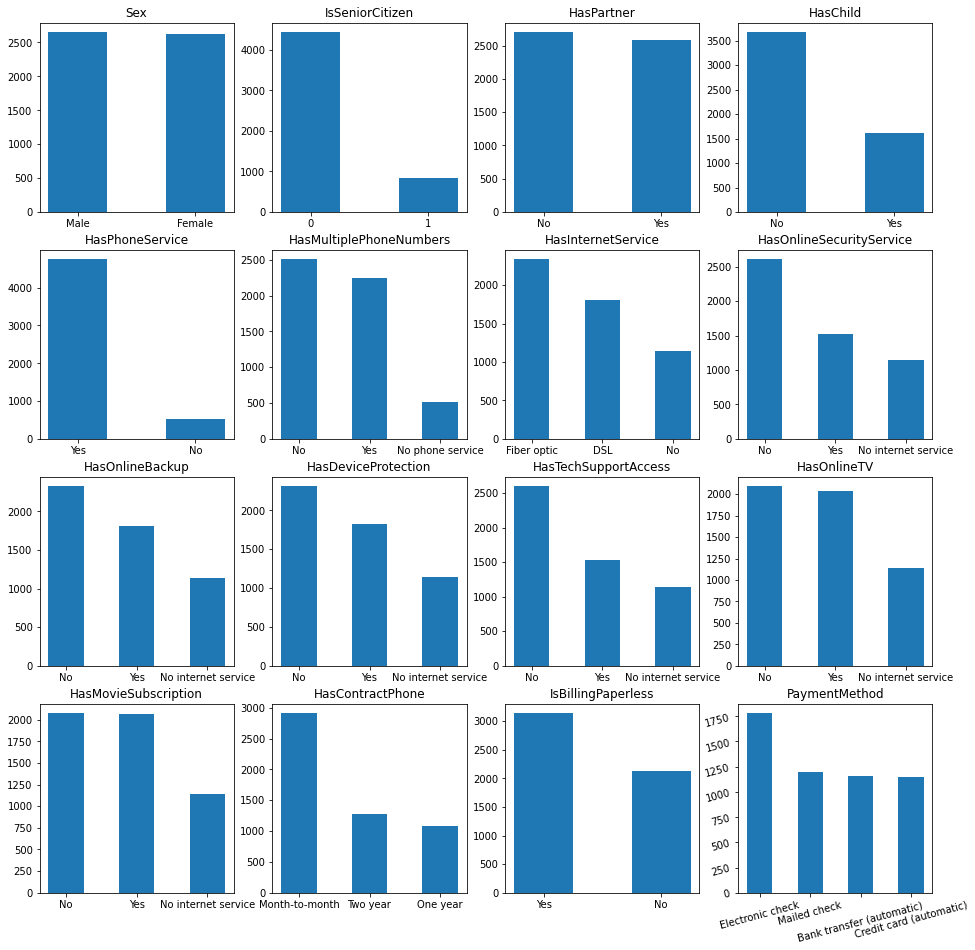

In [11]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    x = np.arange(len(labels))
    ax[i].set_title(column)
    ax[i].bar(x, values, width=0.5)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    if i == 15:
        ax[i].tick_params(labelrotation=15)

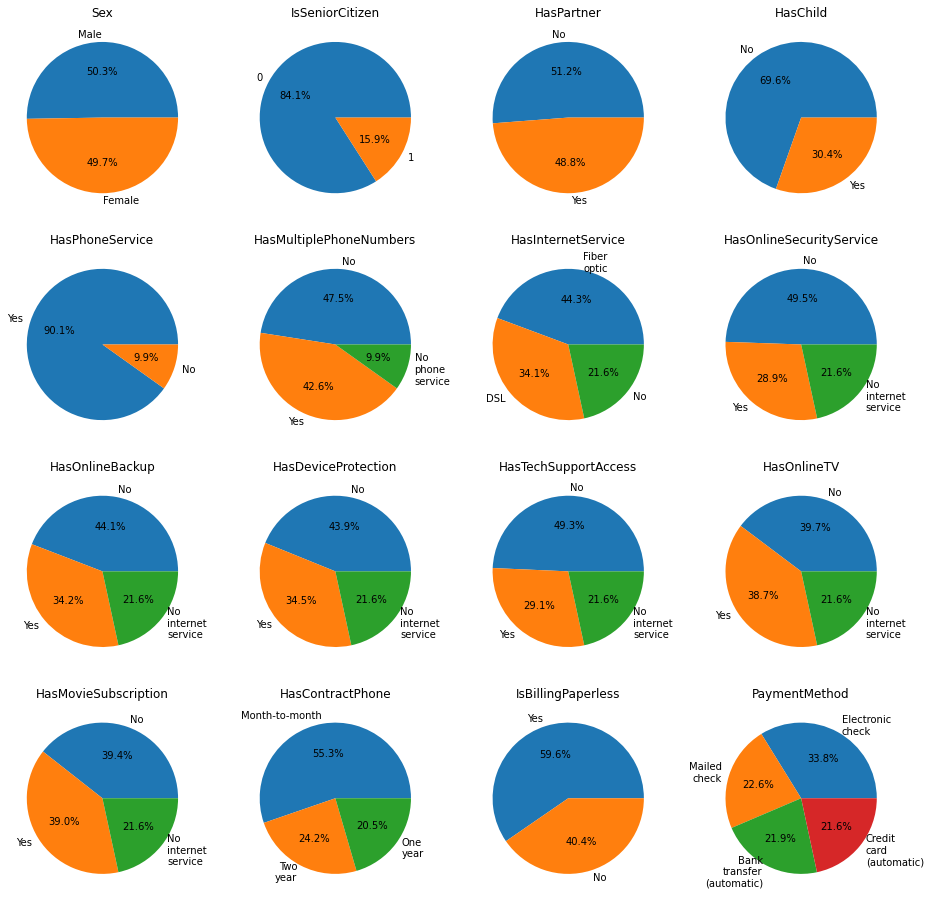

In [13]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = train[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    ax[i].set_title(column)
    ax[i].pie(values,
              labels=[str(s).replace(' ', '\n') for s in labels],
              autopct='%1.1f%%')

In [12]:
#Нормирование
cb_train = train.copy()
cb_test = test.copy()

y = train[target_col]

In [14]:
dummy_data = pd.get_dummies(train[cat_cols], drop_first=True) # drop_first=True
train = pd.concat([train[num_cols], dummy_data], axis=1)

In [16]:
train = pd.concat([train[num_cols], dummy_data], axis=1)

In [17]:
dummy_data = pd.get_dummies(test[cat_cols], drop_first=True) # drop_first=True
test = pd.concat([test[num_cols], dummy_data], axis=1)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, random_state=1)

In [ ]:
#Нормирование числовых признаков
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
train[num_cols] = scaler.transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [19]:
#Обучение моделей
X_train

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Male,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
246,68,108.45,7176.55,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0
3847,31,79.85,2404.15,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
471,45,100.30,4483.95,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,1,0,1,0
1102,5,44.80,220.45,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
759,1,50.75,50.75,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,43,84.85,3645.60,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
5192,1,69.65,69.65,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3980,24,99.30,2431.35,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1,0,0
235,22,79.20,1742.75,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0


In [20]:
models_params = {
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 30, 50, 100],
        }
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators' : [30, 50, 70, 100, 150, 200],
            'min_samples_split': [5, 10, 15, 20, 25, 30]
        }
    },
    
    'svm' : {
        'model': svm.SVC(gamma = 'auto'),
        'params': {
            'C': [1, 10, 20], 
            'kernel': ['rbf', 'linear']
        }
    },    
}

In [ ]:
score_table = list()
for model_name, value in models_params.items():
    clf = GridSearchCV(
        value['model'],
        value['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=10,
    )
    clf.fit(train, y)
    print(clf.cv_results_['mean_test_score'])
    score_table.append({
        'model': model_name ,
        'best_score': clf.best_score_ ,
        'best_params': clf.best_params_,
        'best_model': clf.best_estimator_
    })

In [23]:
pd.DataFrame(score_table, columns=['model', 'best_score', 'best_params'])

,model,best_score,best_params
0,logistic_regression,0.842494,{'C': 1}


In [24]:
y_pred = score_table[0]['best_model'].predict_proba(test)[:,-1]

In [25]:
#Градиентный бустин
import xgboost

params = {
#     'booster': ['gbtree'],
#     'n_estimators' : [8, 10, 12],
#     'eta': [0.07, 0.1, 0.12],
#     'max_depth': [7, 10, 12],
#     'min_child_weight': [6, 7, 8, 9],
#     'gamma': [0.03, 0.05, 0.07],
#     'colsample_bytree': [0.25, 0.3, 0.35],
    'booster': ['gblinear'],
    'n_estimators': [10000],
    'updater': ['shotgun']
}
clf = GridSearchCV(
    xgboost.XGBClassifier(),
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=10
)
clf.fit(train, y)
print(clf.cv_results_['mean_test_score'])
print(clf.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0.80783868]
{'booster': 'gblinear', 'n_estimators': 10000, 'updater': 'shotgun'}


In [26]:
max(clf.cv_results_['mean_test_score'])

0.8078386788445974

In [ ]:
pd.options.display.max_colwidth = 200
pd.DataFrame([
    [{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.07, 'gamma': 0.07, 'max_depth': 12, 'min_child_weight': 9, 'n_estimators': 10}, 0.8409537799837079],
    [{'colsample_bytree': 0.3, 'eta': 0.05, 'gamma': 0.0, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 10}, 0.8414464698372527],
    [{'colsample_bytree': 0.3, 'eta': 0.1, 'gamma': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 10}, 0.842736281878973],
    [{'booster': 'gbtree', 'colsample_bytree': 0.35, 'eta': 0.12, 'gamma': 0.07, 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 10}, 0.8436879028707965],
    [{'booster': 'gblinear', 'eta': 0.15, 'lambda': 0, 'n_estimators': 500, 'updater': 'coord_descent'}, 0.844827631927552],
    [{'booster': 'gblinear', 'n_estimators': 500}, 0.8448524559481427],
    [{'booster': 'gblinear', 'n_estimators': 1000, 'updater': 'shotgun'}, 0.8449470472449274]
], columns=['best_params', 'mean_test_score'])

In [ ]:
y_pred = clf.best_estimator_.predict_proba(test)[:,-1]

In [ ]:
import catboost

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    cb_train[feature_cols], y, train_size=0.8, random_state=1, stratify=y
)

In [ ]:
boost_model = catboost.CatBoostClassifier(n_estimators=500, cat_features=cat_cols)
boost_model.fit(X_train, y_train)
y_train_pred = boost_model.predict_proba(X_train)[:, 1]
y_valid_pred = boost_model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_valid, y_valid_pred)

In [ ]:
#Пробуем подобрать
params = {
#     "learning_rate":[0.025, 0.03, 0.04],
#     "min_data_in_leaf":[88, 90, 92],
#     "depth": [3, 4, 5],
#     "iterations":[187, 190, 193]
# iter0
#     'learning_rate': [0.01, 0.05, 0.1],
#     'min_data_in_leaf': [10, 50, 100],
#     'depth': [3, 5, 10],
#     'iterations': [100, 200, 300]
# iter1
#     'learning_rate': [0.07, 0.1, 0.15],
#     'min_data_in_leaf': [5, 10, 20],
#     'depth': [4, 5, 7],
#     'iterations': [50, 100, 150]
# iter2
#     'learning_rate': [0.05, 0.1, 0.15],
#     'min_data_in_leaf': [10, 15, 20],
#     'depth': [4, 5, 6, 7],
#     'iterations': [100, 120, 150]
# iter3
    'learning_rate': [0.07, 0.1, 0.12],
    'min_data_in_leaf': [10, 12, 14],
    'depth': [5],
    'iterations': [110, 120, 130]
# iter4
#     'learning_rate': [0.08, 0.1, 0.12],
#     'min_data_in_leaf': [8, 9, 10, 12, 14],
#     'depth': [4, 5, 6],
#     'iterations': [100, 105, 110, 120, 130]

}
boost_model = catboost.CatBoostClassifier(cat_features=cat_cols, random_seed=1, verbose=False)
result = boost_model.grid_search(params, X_train, y_train)

In [ ]:
pd.DataFrame([[
    roc_auc_score(y_train, boost_model.predict_proba(X_train)[:, 1]),
    roc_auc_score(y_valid, boost_model.predict_proba(X_valid)[:, 1]),
    result['params'],
]])

In [ ]:
#Некоторые старые результаты
pd.DataFrame([
    [0.859125, 0.855956, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 100, 'learning_rate': 0.1}],
    [0.85573, 0.855295, {'min_data_in_leaf': 5, 'depth': 4, 'iterations': 150, 'learning_rate': 0.07}],
    [0.859285, 0.856213, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 120, 'learning_rate': 0.1}],
    [0.859223, 0.856096, {'min_data_in_leaf': 10, 'depth': 5, 'iterations': 110, 'learning_rate': 0.1}],
    [0.859723, 0.856381, {'min_data_in_leaf': 8, 'depth': 6, 'iterations': 105, 'learning_rate': 0.08}],
])

In [ ]:
#Предсказания
y_pred = boost_model.predict_proba(cb_test)[:,-1]

In [ ]:
submission = pd.read_csv(
    'submission.csv',
    index_col='Id'
)
submission['Churn'] = y_pred
submission.to_csv('my_submission.csv')